In [4]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'H:\Tesseract\tesseract.exe'

In [5]:
image = cv2.imread("images/numbers.jpg")

# Grayscale, Gaussian blur, Otsu's threshold
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Morph open to remove noise and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
invert = 255 - opening

# Perform text extraction
data = pytesseract.image_to_string(invert, lang='eng', config='--psm 5 --oem 3 -c tessedit_char_whitelist=0123456789')
print(data)

In [ ]:
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(pytesseract.image_to_string(img_rgb))

cv2.imshow('thresh', thresh)
cv2.imshow('opening', opening)
cv2.imshow('invert', invert)
cv2.waitKey()

A789



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import random

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import language_check
from string import punctuation

from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# kappa metric for measuring agreement of automatic to human scores
from sklearn.metrics import cohen_kappa_score, confusion_matrix

In [13]:
def kappa(y_true, y_pred, weights=None, allow_off_by_one=False):
    """
    From https://github.com/EducationalTestingService/skll/blob/master/skll/metrics.py
    
    Calculates the kappa inter-rater agreement between two the gold standard
    and the predicted ratings. Potential values range from -1 (representing
    complete disagreement) to 1 (representing complete agreement).  A kappa
    value of 0 is expected if all agreement is due to chance.
    In the course of calculating kappa, all items in ``y_true`` and ``y_pred`` will
    first be converted to floats and then rounded to integers.
    It is assumed that y_true and y_pred contain the complete range of possible
    ratings.
    This function contains a combination of code from yorchopolis's kappa-stats
    and Ben Hamner's Metrics projects on Github.
    Parameters
    ----------
    y_true : array-like of float
        The true/actual/gold labels for the data.
    y_pred : array-like of float
        The predicted/observed labels for the data.
    weights : str or np.array, optional
        Specifies the weight matrix for the calculation.
        Options are ::
            -  None = unweighted-kappa
            -  'quadratic' = quadratic-weighted kappa
            -  'linear' = linear-weighted kappa
            -  two-dimensional numpy array = a custom matrix of
        weights. Each weight corresponds to the
        :math:`w_{ij}` values in the wikipedia description
        of how to calculate weighted Cohen's kappa.
        Defaults to None.
    allow_off_by_one : bool, optional
        If true, ratings that are off by one are counted as
        equal, and all other differences are reduced by
        one. For example, 1 and 2 will be considered to be
        equal, whereas 1 and 3 will have a difference of 1
        for when building the weights matrix.
        Defaults to False.
    Returns
    -------
    k : float
        The kappa score, or weighted kappa score.
    Raises
    ------
    AssertionError
        If ``y_true`` != ``y_pred``.
    ValueError
        If labels cannot be converted to int.
    ValueError
        If invalid weight scheme.
    """

    # Ensure that the lists are both the same length
    assert(len(y_true) == len(y_pred))

    # This rather crazy looking typecast is intended to work as follows:
    # If an input is an int, the operations will have no effect.
    # If it is a float, it will be rounded and then converted to an int
    # because the ml_metrics package requires ints.
    # If it is a str like "1", then it will be converted to a (rounded) int.
    # If it is a str that can't be typecast, then the user is
    # given a hopefully useful error message.
    try:
        y_true = [int(np.round(float(y))) for y in y_true]
        y_pred = [int(np.round(float(y))) for y in y_pred]
    except ValueError:
        raise ValueError("For kappa, the labels should be integers or strings "
                         "that can be converted to ints (E.g., '4.0' or '3').")

    # Figure out normalized expected values
    min_rating = min(min(y_true), min(y_pred))
    max_rating = max(max(y_true), max(y_pred))

    # shift the values so that the lowest value is 0
    # (to support scales that include negative values)
    y_true = [y - min_rating for y in y_true]
    y_pred = [y - min_rating for y in y_pred]

    # Build the observed/confusion matrix
    num_ratings = max_rating - min_rating + 1
    observed = confusion_matrix(y_true, y_pred,
                                labels=list(range(num_ratings)))
    num_scored_items = float(len(y_true))

    # Build weight array if weren't passed one
    if isinstance(weights, str):
        wt_scheme = weights
        weights = None
    else:
        wt_scheme = ''
    if weights is None:
        weights = np.empty((num_ratings, num_ratings))
        for i in range(num_ratings):
            for j in range(num_ratings):
                diff = abs(i - j)
                if allow_off_by_one and diff:
                    diff -= 1
                if wt_scheme == 'linear':
                    weights[i, j] = diff
                elif wt_scheme == 'quadratic':
                    weights[i, j] = diff ** 2
                elif not wt_scheme:  # unweighted
                    weights[i, j] = bool(diff)
                else:
                    raise ValueError('Invalid weight scheme specified for '
                                     'kappa: {}'.format(wt_scheme))

    hist_true = np.bincount(y_true, minlength=num_ratings)
    hist_true = hist_true[: num_ratings] / num_scored_items
    hist_pred = np.bincount(y_pred, minlength=num_ratings)
    hist_pred = hist_pred[: num_ratings] / num_scored_items
    expected = np.outer(hist_true, hist_pred)

    # Normalize observed array
    observed = observed / num_scored_items

    # If all weights are zero, that means no disagreements matter.
    k = 1.0
    if np.count_nonzero(weights):
        k -= (sum(sum(weights * observed)) / sum(sum(weights * expected)))

    return k

In [14]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py

numpy = np

def rater_confusion_matrix(rater_a, rater_b,
    min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a)==len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    num_ratings = max_rating - min_rating + 1
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a,b in zip(rater_a,rater_b):
        conf_mat[a-min_rating][b-min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None: min_rating = reduce(min, ratings)
    if max_rating is None: max_rating = reduce(max, ratings)
    num_ratings = max_rating - min_rating + 1
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r-min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b,
                             min_rating = None, max_rating = None):
    """
    Calculates the quadratic weighted kappa
    scoreQuadraticWeightedKappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1  
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    
    scoreQuadraticWeightedKappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
   
    score_quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    conf_mat = rater_confusion_matrix(rater_a, rater_b,
                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i]*hist_rater_b[j]
                    / num_scored_items) 
            d = pow(i-j,2.0) / pow(num_ratings-1, 2.0)
            numerator += d*conf_mat[i][j] / num_scored_items
            denominator += d*expected_count / num_scored_items

    return 1.0 - numerator / denominator

def linear_weighted_kappa(rater_a, rater_b,
                             min_rating = None, max_rating = None):
    """
    Calculates the linear weighted kappa
    linear_weighted_kappa calculates the linear weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1  
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    
    linear_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
   
    linear_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    conf_mat = rater_confusion_matrix(rater_a, rater_b,
                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i]*hist_rater_b[j]
                        / num_scored_items) 
            d = abs(i-j) / float(num_ratings-1)
            numerator += d*conf_mat[i][j] / num_scored_items
            denominator += d*expected_count / num_scored_items

    return 1.0 - numerator / denominator

def kappabh(rater_a, rater_b,
                             min_rating = None, max_rating = None):
    """
    Calculates the kappa
    kappa calculates the kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1  
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    
    kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
   
    kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    conf_mat = rater_confusion_matrix(rater_a, rater_b,
                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i]*hist_rater_b[j]
                        / num_scored_items) 
            if i==j:
                d=0.0
            else:
                d=1.0
            numerator += d*conf_mat[i][j] / num_scored_items
            denominator += d*expected_count / num_scored_items

    return 1.0 - numerator / denominator

def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = numpy.array(kappas, dtype=float)
    if weights is None:
        weights = numpy.ones(numpy.shape(kappas))
    else:
        weights = weights / numpy.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = numpy.array([min(x, .999) for x in kappas])
    kappas = numpy.array([max(x, -.999) for x in kappas])
    
    z = 0.5 * numpy.log( (1+kappas)/(1-kappas) ) * weights
    z = numpy.mean(z)
    kappa = (numpy.exp(2*z)-1) / (numpy.exp(2*z)+1)
    return kappa

In [15]:
essay_sets  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
essay_sets.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
8136,12884,5,"The mood the author Narciso Rodriguez, creates...",2,2,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
essay_sets['word_count'] = essay_sets['essay'].str.strip().str.split().str.len()

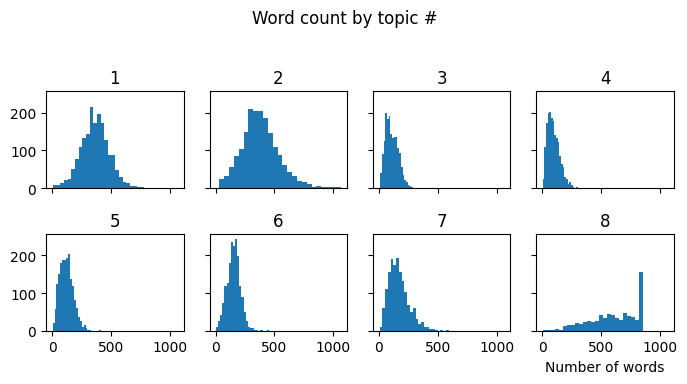

In [17]:
essay_sets.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
text = 'Some people are still using Myspoce instead of facdbook'

tool = language_check.LanguageTool('en-US')

matches = tool.check(text)
language_check.correct(text, matches)

'Some people are still using MySpace instead of Facebook'

In [19]:
# don't need to rerun

tool = language_check.LanguageTool('en-US')

t0 = datetime.now()

essay_sets['matches'] = essay_sets['essay'].apply(lambda txt: tool.check(txt))
essay_sets['corrections'] = essay_sets.apply(lambda l: len(l['matches']), axis=1)
essay_sets['corrected'] = essay_sets.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save work
essay_sets.to_pickle('training_corr.pkl')

Processing time: 0:12:22.550962


In [20]:
essay_sets = pd.read_pickle('training_corr.pkl')

In [23]:
# don't need to rerun
import en_core_web_sm

sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = en_core_web_sm.load()

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(essay_sets['corrected'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

essay_sets['tokens'] = tokens
essay_sets['lemma'] = lemma
essay_sets['pos'] = pos
essay_sets['sents'] = sents
essay_sets['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save work
essay_sets.to_pickle('training_spacy.pkl')

Processing time: 0:04:46.187790


In [24]:
random_essay = random.randrange(12976)
essay = essay_sets.iloc[random_essay]

print('Original:')
print(essay.essay)
print(' ')

print('Corrected with languagetool:')
print(essay.corrected)

Original:
When I was @NUM1 years old my mother and sister were working and cleaning around the house and I kept asking my @CAPS3 can we go to get pizza? @CAPS1 every time I asked she would reply, if you help us and we finish before dinner, we can go get pizza. I didnt want to wash windows, clean my room or wash the car. So I waited on the playground in the back yard swinging and going down the slide, @CAPS1 after @NUM2 minutes, it got boring. After that, thats when I knew I would have to be patient. I ran down the hill to the river and waded into its cold water. @CAPS1 I was still bored. I got out of the river and ran to @CAPS3. @CAPS2 are you and @PERSON1 done yet? I asked. Were done with the house @CAPS1 the car has yet to be washed she answered. I walk to my bike and got my helmet which is sitting on my bike seat. The wind in my face was nothing compared to eating pizza, @CAPS1 somehow driving up and down the drive way was more entertaining than cleaning. I hop of my bicycl

In [25]:
essay_sets = pd.read_pickle('training_spacy.pkl')

essay_sets[['tokens', 'pos', 'sents', 'ner']].head()

,tokens,pos,sents,ner
0,"[Dear, local, newspaper, ,, I, think, effects,...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN...","[Dear local newspaper, I think effects compute...","[Facebook, @DATE1, all day]"
1,"[Dear, @CAPS1, @CAPS2, ,, I, believe, that, us...","[ADJ, PUNCT, INTJ, PUNCT, PRON, VERB, SCONJ, V...","[Dear @CAPS1 @CAPS2, I believe that using comp...","[Facebook, MySpace, millions, one, MySpace, Fa..."
2,"[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, m...","[ADJ, PUNCT, PUNCT, PUNCT, VERB, ADJ, CCONJ, A...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more peop...","[today, one, one, a thousand, @ORGANIZATION1]"
3,"[Dear, Local, Newspaper, ,, @CAPS1, I, have, f...","[PROPN, PROPN, PROPN, PUNCT, PUNCT, PRON, AUX,...","[Dear Local Newspaper, @CAPS1, I have found th...","[Dear Local Newspaper, @CAPS1, @PERSON1, @PERS..."
4,"[Dear, @LOCATION1, ,, I, know, having, compute...","[ADJ, PROPN, PUNCT, PRON, VERB, VERB, NOUN, AU...","[Dear @LOCATION1, I know having computers has ...","[First, one, Mae, Secondly, one, only one]"


In [26]:
tokens = nlp("dog cat banana")

for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

dog dog 1.0
dog cat 0.45290068
dog banana 0.254213
cat dog 0.45290068
cat cat 1.0
cat banana 0.38413918
banana dog 0.254213
banana cat 0.38413918
banana banana 1.0


In [27]:
# don't need to rerun

"""Choose arbitrary essay from highest available target_score for each topic.
all other essays will be compared to these. 
The uncorrected essays will be used since the reference essays should have fewer errors.
"""
reference_essays = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340} # topic: essay_id

references = {}

t0 = datetime.now()

stop_words = set(STOP_WORDS)

# generate nlp object for reference essays:
for topic, index in reference_essays.items():
    references[topic] = nlp(essay_sets.iloc[index]['essay'])

# generate document similarity for each essay compared to topic reference
essay_sets['similarity'] = essay_sets.apply(lambda row: nlp(row['essay']).similarity(references[row['topic']]), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:05:41.933680


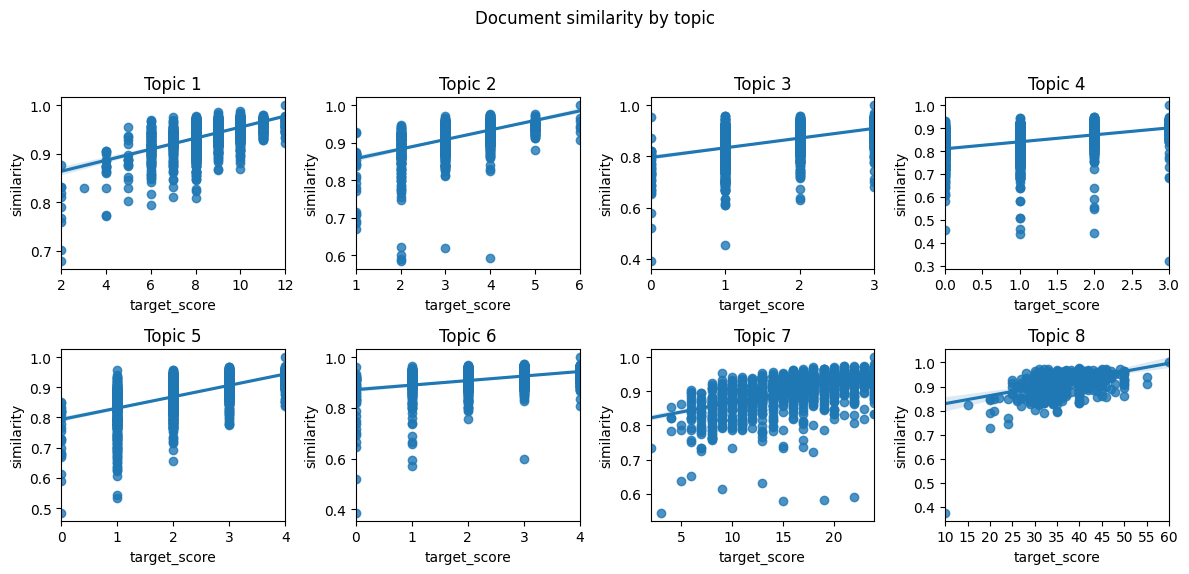

In [28]:
# Plot document similarity vs target score for each topic
topic_number = 0
fig, ax = plt.subplots(2,4, figsize=(12,6))
for i in range(2):
    for j in range(4):
        topic_number += 1
        sns.regplot(x='target_score', y='similarity', data=essay_sets[essay_sets['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[0,3].locator_params(nbins=10)
ax[1,3].locator_params(nbins=10)
plt.suptitle('Document similarity by topic')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('image5.png', dpi=300)
plt.show()

In [125]:
def get_score(topic, score):
    if topic == 1:
        min = 2
        max = 12
        
    elif topic == 2:
        min = 1
        max = 6
        
    elif topic == 3 or topic == 4:
        min = 0
        max = 3
        
    elif topic == 5 or topic == 6:
        min = 0
        max = 4

    elif topic == 7:
        min = 0
        max = 30
        
    elif topic == 8:
        min = 0
        max = 60
        
    return (score - min) * (100 - 1) / (max - min) + 1
                                

In [129]:
# don't need to rerun

# count various features

t0 = datetime.now()

essay_sets['token_count'] = essay_sets.apply(lambda x: len(x['tokens']), axis=1)
essay_sets['unique_token_count'] = essay_sets.apply(lambda x: len(set(x['tokens'])), axis=1)
essay_sets['nostop_count'] = essay_sets \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
essay_sets['sent_count'] = essay_sets.apply(lambda x: len(x['sents']), axis=1)
essay_sets['ner_count'] = essay_sets.apply(lambda x: len(x['ner']), axis=1)
essay_sets['comma'] = essay_sets.apply(lambda x: x['corrected'].count(','), axis=1)
essay_sets['question'] = essay_sets.apply(lambda x: x['corrected'].count('?'), axis=1)
essay_sets['exclamation'] = essay_sets.apply(lambda x: x['corrected'].count('!'), axis=1)
essay_sets['quotation'] = essay_sets.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
essay_sets['organization'] = essay_sets.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
essay_sets['caps'] = essay_sets.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
essay_sets['person'] = essay_sets.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
essay_sets['location'] = essay_sets.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
essay_sets['money'] = essay_sets.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
essay_sets['time'] = essay_sets.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
essay_sets['date'] = essay_sets.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
essay_sets['percent'] = essay_sets.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
essay_sets['noun'] = essay_sets.apply(lambda x: x['pos'].count('NOUN'), axis=1)
essay_sets['adj'] = essay_sets.apply(lambda x: x['pos'].count('ADJ'), axis=1)
essay_sets['pron'] = essay_sets.apply(lambda x: x['pos'].count('PRON'), axis=1)
essay_sets['verb'] = essay_sets.apply(lambda x: x['pos'].count('VERB'), axis=1)
essay_sets['noun'] = essay_sets.apply(lambda x: x['pos'].count('NOUN'), axis=1)
essay_sets['cconj'] = essay_sets.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
essay_sets['adv'] = essay_sets.apply(lambda x: x['pos'].count('ADV'), axis=1)
essay_sets['det'] = essay_sets.apply(lambda x: x['pos'].count('DET'), axis=1)
essay_sets['propn'] = essay_sets.apply(lambda x: x['pos'].count('PROPN'), axis=1)
essay_sets['num'] = essay_sets.apply(lambda x: x['pos'].count('NUM'), axis=1)
essay_sets['part'] = essay_sets.apply(lambda x: x['pos'].count('PART'), axis=1)
essay_sets['intj'] = essay_sets.apply(lambda x: x['pos'].count('INTJ'), axis=1)


essay_sets['adjusted_score'] = essay_sets.apply(lambda x: get_score(x['topic'], x['target_score']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save to file
essay_sets.to_pickle('training_features.pkl')

Processing time: 0:00:10.630461


In [130]:
essay_sets = pd.read_pickle('training_features.pkl')

In [137]:
all_features = [  
                'word_count',
                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj',
                ]

In [136]:
essay_sets[['topic', 'target_score', 'adjusted_score']]

,topic,target_score,adjusted_score
0,1,8,60.40
1,1,9,70.30
2,1,7,50.50
3,1,10,80.20
4,1,8,60.40
...,...,...,...
12971,8,35,58.75
12972,8,32,53.80
12973,8,40,67.00
12974,8,40,67.00


In [33]:
# Create empty dataframe
df = pd.DataFrame()

# Create and fit selector
selector = SelectKBest(f_regression, k=10) # f_classif, chi2, f_regression, mutual_info_classif, mutual_info_regression

for topic in range(1, 9):
    kpredictors = []
    
    # test for division by zero errors due to insufficient data:
    for p in omit_features:
        if np.std(essay_sets[essay_sets.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)
            
    # select k best for each topic:
    X = essay_sets[essay_sets.topic == topic][kpredictors]
    y = essay_sets[essay_sets.topic == topic].target_score
    
    selector.fit(X, y)

    # Get idxs of columns to keep
    mask = selector.get_support(indices=True)

    selected_features = essay_sets[essay_sets.topic == topic][omit_features].columns[mask]
    df["Topic " + str(topic)] = selected_features
df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,similarity,similarity,similarity,unique_token_count,similarity,similarity,similarity,similarity
1,unique_token_count,unique_token_count,unique_token_count,sent_count,unique_token_count,unique_token_count,unique_token_count,unique_token_count
2,sent_count,sent_count,sent_count,comma,sent_count,sent_count,sent_count,sent_count
3,comma,comma,comma,percent,comma,comma,ner_count,comma
4,noun,noun,date,noun,date,date,noun,noun
5,adj,adj,percent,pron,percent,percent,adj,adj
6,verb,verb,adj,verb,adj,adj,pron,verb
7,cconj,adv,pron,cconj,pron,verb,verb,adv
8,adv,det,verb,adv,verb,cconj,adv,det
9,det,part,cconj,det,cconj,adv,det,part
